In [1]:
# 忽略warnings
import warnings 
warnings.filterwarnings('ignore') 

# 强制使用CPU
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 导入Python通用库
import matplotlib.pyplot as plt
import numpy as np
import os

# 导入TF 2.0并设置GPU
import tensorflow as tf
# 导入Keras库
from tensorflow import keras
# 设置使用GPU显存的比例
# from keras.backend.tensorflow_backend import set_session
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.6
# tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config)) 
# 导入util模块的各种方法
# from keras.utils.np_utils import to_categorical
# 导入数据集
from keras.datasets import imdb
# 导入模型、优化器、损失函数等等
from keras import preprocessing
from keras import regularizers
from keras import optimizers
from keras import metrics
from keras import models
from keras import losses
from keras import layers
# 导入Keras字符处理模块
from keras.layers import Dense, Embedding, SimpleRNN, LSTM
from keras.preprocessing import sequence
# from keras.preprocessing.text import Tokenizer
from keras.models import Sequential

Using TensorFlow backend.


# 06. 深度学习用于文本和序列
本章将介绍使用深度学习模型处理文本、时间序列和一般的序列数据。用于处理序列的两种基本的深度学习算法分别是`循环神经网络`（recurrent neural network）和`一维卷积神经网络`（1D convnet），后者是上一章介绍的二维卷积神经网络的一维版本。本章将讨论这两种方法。

这些算法的应用包括：
+ 文档分类和时间序列分类，比如识别文章的主题或书的作者
+ 时间序列对比，比如估测两个文档或两支股票行情的相关程度
+ 序列到序列的学习，比如将英语翻译成法语
+ 情感分析，比如将推文或电影评论的情感划分为正面或负面
+ 时间序列预测，比如根据某地最近的天气数据来预测未来天气

## 6.2 理解循环神经网络
目前你见过的所有神经网络（比如密集连接网络和卷积神经网络）都有一个主要特点，那就是它们都没有记忆。它们单独处理每个输入，在输入与输入之间没有保存任何状态。对于这样的网络，要想处理数据点的序列或时间序列，你需要向网络同时展示整个序列，即将序列转换成单个数据点。例如，你在`IMDB`示例中就是这么做的：将全部电影评论转换为一个大向量，然后一次性处理。这种网络叫作`前馈网络`（feedforward network）。

与此相反，当你在阅读这个句子时，你是一个词一个词地阅读，同时会记住之前的内容。这让你能够动态理解这个句子所传达的含义。生物智能以渐进的方式处理信息，同时保存一个关于所处理内容的内部模型，这个模型是根据过去的信息构建的，并随着新信息的进入而不断更新。

`循环神经网络`（RNN，recurrent neural network）采用同样的原理，不过是一个极其简化的版本：它处理序列的方式是，遍历所有序列元素，并保存一个`状态`（state），其中包含与已查看内容相关的信息。实际上，RNN是一类具有内部环的神经网络（见`图6-9`）。在处理两个不同的独立序列（比如两条不同的`IMDB`评论）之间，RNN状态会被重置，因此，你仍可以将一个序列看作单个数据点，即网络的单个输入。真正改变的是，数据点不再是在单个步骤中进行处理，相反，网络内部会对序列元素进行遍历。

<img src="images/06_09.png" style="width:300px;"/>

为了将`环`（loop）和`状态`（state）的概念解释清楚，我们用`Numpy`来实现一个简单`RNN`的前向传递。这个`RNN`的输入是一个张量序列，我们将其编码成大小为`(timesteps, input_features)`的二维张量。它对`时间步`（timestep）进行遍历，在每个时间步，它考虑`t`时刻的当前状态与`t`时刻的输入【形状为`(input_features,)`】，对二者计算得到`t`时刻的输出。然后，我们将下一个时间步的状态设置为上一个时间步的输出。对于第一个时间步，上一个时间步的输出没有定义，所以它没有当前状态。因此，你需要将状态初始化为一个全零向量，这叫作网络的`初始状态`（initial state）。

`RNN`的伪代码如下所示：

```python
# t时刻的状态
state_t = 0
# 对序列元素进行遍历
for input_t in input_sequence: 
    output_t = f(input_t, state_t)
    # 前一次的输出变成下一次迭代的状态
    state_t = output_t 
```

你甚至可以给出具体的函数$f$：从输入和状态到输出的变换，其参数包括两个矩阵（$W$和$U$）和一个偏置向量。它类似于前馈网络中密集连接层所做的变换：
```python
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t
```

为了将这些概念的含义解释得更加清楚，我们为简单`RNN`的前向传播编写一个简单的`Numpy`实现。

In [2]:
# 输入序列的时间步数
timesteps = 100
# 输入特征空间的维度
input_features = 32 
# 输出特征空间的维度
output_features = 64 
# 输入数据：随机噪声，仅作为示例
inputs = np.random.random((timesteps, input_features))
# 初始状态：全零向量
state_t = np.zeros((output_features,)) 
# （以下3行）创建随机的权重矩阵
W = np.random.random((output_features, input_features)) 
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))                   
# 保存结果
successive_outputs = []
# input_t是形状为(input_features,)的向量
for input_t in inputs: 
    # 由输入和当前状态（前一个输出）计算得到当前输出
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b) 
    # 将这个输出保存到一个列表中
    successive_outputs.append(output_t)  
    # 更新网络的状态，用于下一个时间步
    state_t = output_t 
# 最终输出是一个形状为(timesteps, output_features)的二维张量
final_output_sequence = np.stack(successive_outputs, axis=0)

足够简单。总之，`RNN`是一个 for 循环，它重复使用循环前一次迭代的计算结果，仅此而已。当然，你可以构建许多不同的`RNN`，它们都满足上述定义。这个例子只是最简单的`RNN`表述之一。`RNN`的特征在于其时间步函数，比如前面例子中的这个函数（见`图6-10`）。

<img src="images/06_10.png" style="width:600px;"/>

> **注意**　
> 本例中，最终输出是一个形状为`(timesteps, output_features)`的二维张量，其中每个时间步是循环在`t`时刻的输出。输出张量中的每个时间步`t`包含输入序列中时间步`0~t`的信息，即关于全部过去的信息。因此，在多数情况下，你并不需要这个所有输出组成的序列，你只需要最后一个输出（循环结束时的`output_t`），因为它已经包含了整个序列的信息

### 6.2.1 Keras 中的循环层
上面`Numpy`的简单实现，对应一个实际的`Keras`层，即`SimpleRNN`层。

二者有一点小小的区别：`SimpleRNN`层能够像其他`Keras`层一样处理序列批量，而不是像`Numpy`示例那样只能处理单个序列。因此，它接收形状为`(batch_size, timesteps, input_features)`的输入，而不是`(timesteps, input_features)`。

与`Keras`中的所有循环层一样，`SimpleRNN`可以在两种不同的模式下运行：一种是返回每个时间步连续输出的完整序列，即形状为`(batch_size, timesteps, output_features)`的三维张量；另一种是只返回每个输入序列的最终输出，即形状为`(batch_size, output_features)`的二维张量。这两种模式由`return_sequences`这个构造函数参数来控制。

我们来看一个使用`SimpleRNN`的例子，它只返回最后一个时间步的输出。

In [3]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


下面这个例子返回完整的状态序列。

In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


为了提高网络的表示能力，将多个循环层逐个堆叠有时也是很有用的。在这种情况下，你需要让所有中间层都返回完整的输出序列。

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
# 最后一层仅返回最终输出
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


接下来，我们将这个模型应用于`IMDB`电影评论分类问题。首先，对数据进行预处理。

In [6]:
# 作为特征的单词个数
max_features = 10000
# 在这么多单词之后截断文本（这些单词都属于前max_features个最常见的单词）
maxlen = 500
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


我们用一个`Embedding`层和一个`SimpleRNN`层来训练一个简单的循环网络。

In [7]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 16s 797us/step - loss: 0.5737 - acc: 0.7025 - val_loss: 0.4811 - val_acc: 0.7788
Epoch 2/10
20000/20000 [==============================] - 16s 788us/step - loss: 0.3650 - acc: 0.8513 - val_loss: 0.4035 - val_acc: 0.8228
Epoch 3/10
20000/20000 [==============================] - 16s 786us/step - loss: 0.2770 - acc: 0.8927 - val_loss: 0.3415 - val_acc: 0.8744
Epoch 4/10
20000/20000 [==============================] - 16s 816us/step - loss: 0.2223 - acc: 0.9164 - val_loss: 0.4546 - val_acc: 0.7954
Epoch 5/10
20000/20000 [==============================] - 17s 831us/step - loss: 0.1960 - acc: 0.9276 - val_loss: 0.3556 - val_acc: 0.8622
Epoch 6/10
20000/20000 [==============================] - 16s 818us/step - loss: 0.1471 - acc: 0.9499 - val_loss: 0.4385 - val_acc: 0.8140
Epoch 7/10
20000/20000

接下来显示训练和验证的损失和精度：

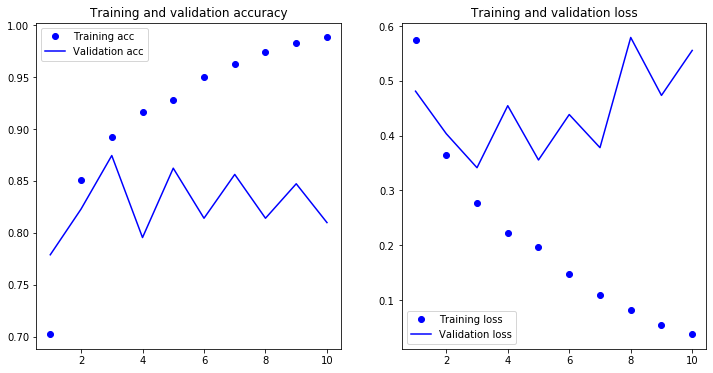

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

提醒一下，在第3章，处理这个数据集的第一个简单方法得到的测试精度是`88%`。不幸的是，与这个基准相比，这个小型循环网络的表现并不好（验证精度只有`85%`）。问题的部分原因在于，输入只考虑了前500个单词，而不是整个序列，因此，RNN获得的信息比前面的基准模型更少。另一部分原因在于，SimpleRNN 不擅长处理长序列，比如文本。

其他类型的循环层的表现要好得多。我们来看几个更高级的循环层。

### 6.2.2 理解 LSTM 层和 GRU 层
`SimpleRNN`并不是`Keras`中唯一可用的循环层，还有另外两个：`LSTM`和`GRU`。在实践中总会用到其中之一，因为`SimpleRNN`通常过于简化，没有实用价值。`SimpleRNN`的最大问题是，在时刻`t`，理论上来说，它应该能够记住许多时间步之前见过的信息，但实际上它是不可能学到这种长期依赖的。其原因在于`梯度消失问题`（vanishing gradient problem），这一效应类似于在层数较多的非循环网络（即前馈网络）中观察到的效应：随着层数的增加，网络最终变得无法训练。Hochreiter、Schmidhuber和Bengio在20世纪90年代初研究了这一效应的理论原因。`LSTM`层和`GRU`层都是为了解决这个问题而设计的。

先来看`LSTM`层。其背后的`长短期记忆`（LSTM，long short-term memory）算法由Hochreiter和Schmidhuber在1997年开发，是二人研究梯度消失问题的重要成果。

`LSTM`层是`SimpleRNN`层的一种变体，它增加了一种携带信息跨越多个时间步的方法。假设有一条传送带，其运行方向平行于你所处理的序列。序列中的信息可以在任意位置跳上传送带，然后被传送到更晚的时间步，并在需要时原封不动地跳回来。这实际上就是`LSTM`的原理：它保存信息以便后面使用，从而防止较早期的信号在处理过程中逐渐消失。

为了详细了解`LSTM`，我们先从`SimpleRNN`单元开始讲起（见`图6-13`）。因为有许多个权重矩阵，所以对单元中的$W$和$U$两个矩阵添加下标字母$o$（$Wo$和$Uo$），表示输出。

<img src="images/06_13.png" style="width:590px;"/>

我们向这张图像中添加额外的数据流，其中携带着跨越时间步的信息。它在不同的时间步的值叫作$Ct$，其中$C$表示`携带`（carry）。这些信息将会对单元产生以下影响：它将与输入连接和循环连接进行运算（通过一个密集变换，即与权重矩阵作点积，然后加上一个偏置，再应用一个激活函数），从而影响传递到下一个时间步的状态（通过一个激活函数和一个乘法运算）。从概念上来看，携带数据流是一种调节下一个输出和下一个状态的方法（见图 6-14）。到目前为止都很简单。

<img src="images/06_14.png" style="width:600px;"/>

下面来看这一方法的精妙之处，即携带数据流下一个值的计算方法。它涉及三个不同的变换，这三个变换的形式都和 SimpleRNN 单元相同：
```python
y = activation(dot(state_t, U) + dot(input_t, W) + b)
```

但这三个变换都具有各自的权重矩阵，我们分别用字母$i$、$f$和$k$作为下标。目前的模型架构如下所示：
```python
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)

i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)
```

对$i\_t$、$f\_t$和$k\_t$进行组合，可以得到新的携带状态（下一个$c\_t$）：
```python
c_t+1 = i_t * k_t + c_t * f_t
```

`图6-15`给出了添加上述架构之后的图示：

<img src="images/06_15.png" style="width:600px;"/>

如果要更哲学一点，你还可以解释每个运算的目的。比如你可以说，将$c\_t$和$f\_t$相乘，是为了故意遗忘携带数据流中的不相关信息。同时，$i\_t$和$k\_t$都提供关于当前的信息，可以用新信息来更新携带轨道。但归根结底，这些解释并没有多大意义，因为这些运算的实际效果是由参数化权重决定的，而权重是以端到端的方式进行学习，每次训练都要从头开始，不可能为某个运算赋予特定的目的。`RNN`单元的类型（如前所述）决定了你的假设空间，即在训练期间搜索良好模型配置的空间，但它不能决定`RNN`单元的作用，那是由单元权重来决定的。同一个单元具有不同的权重，可以实现完全不同的作用。因此，组成`RNN`单元的运算组合，最好被解释为对搜索的一组约束，而不是一种工程意义上的设计。

对于研究人员来说，这种约束的选择（即如何实现`RNN`单元）似乎最好是留给最优化算法来完成（比如遗传算法或强化学习过程），而不是让人类工程师来完成。在未来，那将是我们构建网络的方式。总之，你不需要理解关于`LSTM`单元具体架构的任何内容。作为人类，理解它不应该是你要做的。你只需要记住`LSTM`单元的作用：允许过去的信息稍后重新进入，从而解决梯度消失问题。

### 6.2.3 Keras中一个LSTM的具体例子
现在我们来看一个更实际的问题：使用`LSTM`层来创建一个模型，然后在`IMDB`数据上训练模型。这个网络与前面介绍的`SimpleRNN`网络类似。你只需指定`LSTM`层的输出维度，其他所有参数（有很多）都使用`Keras`默认值。`Keras`具有很好的默认值，无须手动调参，模型通常也能正常运行。

In [9]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 47s 2ms/step - loss: 0.5038 - acc: 0.7606 - val_loss: 0.3474 - val_acc: 0.8632
Epoch 2/10
20000/20000 [==============================] - 46s 2ms/step - loss: 0.2871 - acc: 0.8867 - val_loss: 0.3473 - val_acc: 0.8676
Epoch 3/10
20000/20000 [==============================] - 45s 2ms/step - loss: 0.2322 - acc: 0.9129 - val_loss: 0.4011 - val_acc: 0.8272
Epoch 4/10
20000/20000 [==============================] - 46s 2ms/step - loss: 0.1989 - acc: 0.9289 - val_loss: 0.3043 - val_acc: 0.8682
Epoch 5/10
20000/20000 [==============================] - 47s 2ms/step - loss: 0.1769 - acc: 0.9353 - val_loss: 0.2955 - val_acc: 0.8764
Epoch 6/10
20000/20000 [==============================] - 46s 2ms/step - loss: 0.1548 - acc: 0.9447 - val_loss: 0.5457 - val_acc: 0.8326
Epoch 7/10
20000/20000 [==============================] - 46s 2ms/step - loss: 0.1440 - acc: 0.9504 - val_loss: 0.3242 - val_acc:

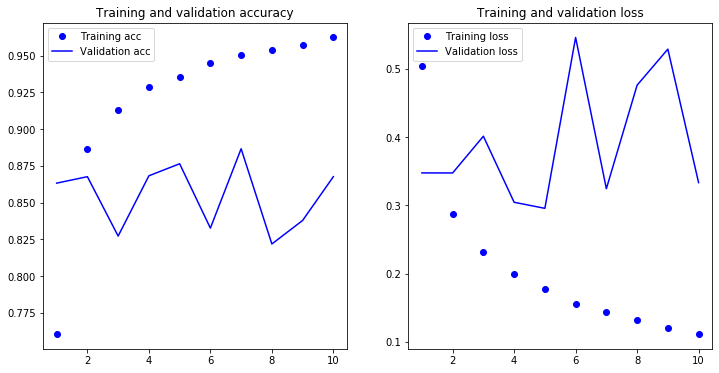

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

这一次，验证精度达到了`89%`。还不错，肯定比`SimpleRNN`网络好多了，这主要是因为`LSTM`受梯度消失问题的影响要小得多。这个结果也比第3章的全连接网络略好，虽然使用的数据量比第3章要少。此处在500个时间步之后将序列截断，而在第3章是读取整个序列。

但对于一种计算量如此之大的方法而言，这个结果也说不上是突破性的。为什么`LSTM`不能表现得更好？一个原因是你没有花力气来调节超参数，比如嵌入维度或`LSTM`输出维度。另一个原因可能是缺少正则化。但说实话，主要原因在于，适用于评论分析全局的长期性结构（这正是`LSTM`所擅长的），对情感分析问题帮助不大。对于这样的基本问题，观察每条评论中出现了哪些词及其出现频率就可以很好地解决。这也正是第一个全连接方法的做法。但还有更加困难的自然语言处理问题，特别是问答和机器翻译，这时 LSTM 的优势就明显了。

### 6.2.4 小结
现在你已经学会了以下内容：
+ `RNN`的概念及其工作原理
+ `LSTM`是什么，为什么它在长序列上的效果要好于普通`RNN`
+ 如何使用`Keras`的`RNN`层来处理序列数据

接下来，我们将介绍`RNN`几个更高级的功能，这可以帮你有效利用深度学习序列模型。

## 6.3 循环神经网络的高级用法
本节将介绍提高循环神经网络的性能和泛化能力的三种高级技巧。我们将在温度预测问题中介绍这三个概念。在这个问题中，数据点时间序列来自建筑物屋顶安装的传感器，包括温度、气压、湿度等，你将要利用这些数据来预测最后一个数据点24小时之后的温度。这是一个相当有挑战性的问题，其中包含许多处理时间序列时经常遇到的困难。

我们将会介绍以下三种技巧：
+ **循环dropout**（recurrent dropout）：这是一种特殊的内置方法，在循环层中使用`dropout`来降低过拟合
+ **堆叠循环层**（stacking recurrent layers）：这会提高网络的表示能力（代价是更高的计算负荷）
+ **双向循环层**（bidirectional recurrent layer）：将相同的信息以不同的方式呈现给循环网络，可以提高精度并缓解遗忘问题

### 6.3.1 温度预测问题
除了语言处理，其他许多问题中也都用到了序列数据。本节我们将使用一个天气时间序列数据集，它由德国耶拿的`马克思 • 普朗克生物地球化学研究所`的气象站记录。

在这个数据集中，每10分钟记录14个不同的量（比如气温、气压、湿度、风向等），其中包含多年的记录。原始数据可追溯到2003年，但本例仅使用2009—2016年的数据。这个数据集非常适合用来学习处理数值型时间序列。我们将会用这个数据集来构建模型，输入最近的一些数据（几天的数据点），可以预测24小时之后的气温。

In [11]:
f = open("./data/jena_climate/jena_climate_2009_2016.csv")
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


从输出可以看出，共有420551行数据（每行是一个时间步，记录了一个日期和14个与天气有关的值）。

接下来，将420551行数据转换成一个`Numpy`数组。

In [12]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

`图6-18`显示了温度（摄氏度）每年的周期性变化：

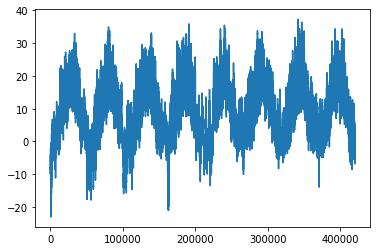

In [13]:
temp = float_data[:, 1] # 温度（单位：摄氏度）
plt.plot(range(len(temp)), temp)
plt.show()

`图6-19`显示了前10天温度数据的图像。因为每10分钟记录一个数据，所以每天有144个数据点。

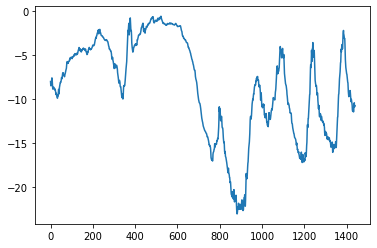

In [14]:
plt.plot(range(1440), temp[:1440])
plt.show()

在这张图中，你可以看到每天的周期性变化，尤其是最后4天特别明显。另外请注意，这10天一定是来自于很冷的冬季月份。

如果你想根据过去几个月的数据来预测下个月的平均温度，那么问题很简单，因为数据具有可靠的年度周期性。但从几天的数据来看，温度看起来更混乱一些。以天作为观察尺度，这个时间序列是可以预测的吗？我们来寻找这个问题的答案。

### 6.3.2 准备数据
这个问题的确切表述如下：一个时间步是10分钟，每`steps`个时间步采样一次数据，给定过去`lookback`个时间步之内的数据，能否预测`delay`个时间步之后的温度？用到的参数值如下：
+ `lookback = 720`：给定过去 5 天内的观测数据
+ `steps = 6`：观测数据的采样频率是每小时一个数据点
+ `delay = 144`：目标是未来 24 小时之后的数据

开始之前，你需要完成以下两件事。
+ 将数据预处理为神经网络可以处理的格式。数据已经是数值型的，所以不需要做向量化。但数据中的每个时间序列位于不同的范围（比如温度通道位于`-20`到`+30`之间，但气压大约在`1000`毫巴上下）。你需要对每个时间序列分别做标准化，让它们在相似的范围内都取较小的值
+ 编写一个`Python`生成器，以当前的浮点数数组作为输入，并从最近的数据中生成数据批量，同时生成未来的目标温度。因为数据集中的样本是高度冗余的（对于第`N`个样本和第`N+1`个样本，大部分时间步都是相同的），所以显式地保存每个样本是一种浪费。相反，我们将使用原始数据即时生成样本

预处理数据的方法是，将每个时间序列减去其平均值，然后除以其标准差。我们将使用前200000个时间步作为训练数据，所以只对这部分数据计算平均值和标准差。

In [15]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

下面的代码给出了将要用到的生成器。它生成了一个元组`(samples, targets)`，其中`samples`是输入数据的一个批量，`targets`是对应的目标温度数组。生成器的参数如下：
+ **data**：标准化后的浮点数数据组成的原始数组
+ **lookback**：输入数据应该包括过去多少个时间步
+ **delay**：目标应该在未来多少个时间步之后
+ **min_index**和**max_index**：data数组中的索引，用于界定需要抽取哪些时间步。这有助于保存一部分数据用于验证、另一部分用于测试
+ **shuffle**：是打乱样本，还是按顺序抽取样本
+ **batch_size**：每个批量的样本数
+ **step**：数据采样的周期（单位：时间步）。我们将其设为6，为的是每小时抽取一个数据点

In [16]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

测试一下：

In [17]:
data = np.arange(0, 1000).reshape(100, -1)
i = 0
for x,y in generator(data, lookback=5, delay=2, min_index=0, max_index=None, batch_size=1, step=1):
    print("samples: ", x)
    print("targets :", y)
    i+=1
    if i > 2:
        break

samples:  [[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
  [10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
  [20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
  [30. 31. 32. 33. 34. 35. 36. 37. 38. 39.]
  [40. 41. 42. 43. 44. 45. 46. 47. 48. 49.]]]
targets : [71.]
samples:  [[[10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
  [20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
  [30. 31. 32. 33. 34. 35. 36. 37. 38. 39.]
  [40. 41. 42. 43. 44. 45. 46. 47. 48. 49.]
  [50. 51. 52. 53. 54. 55. 56. 57. 58. 59.]]]
targets : [81.]
samples:  [[[20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
  [30. 31. 32. 33. 34. 35. 36. 37. 38. 39.]
  [40. 41. 42. 43. 44. 45. 46. 47. 48. 49.]
  [50. 51. 52. 53. 54. 55. 56. 57. 58. 59.]
  [60. 61. 62. 63. 64. 65. 66. 67. 68. 69.]]]
targets : [91.]


下面，我们使用这个抽象的`generator`函数来实例化三个生成器：一个用于训练，一个用于验证，还有一个用于测试。每个生成器分别读取原始数据的不同时间段：训练生成器读取前`200000`个时间步，验证生成器读取随后的`100000`个时间步，测试生成器读取剩下的时间步。

In [18]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

# 为了查看整个验证集，需要从val_gen中抽取多少次
val_steps = (300000 - 200001 - lookback)  //batch_size
# 为了查看整个测试集，需要从test_gen中抽取多少次
test_steps = (len(float_data) - 300001 - lookback)  //batch_size 

### 6.3.3 一种基于常识的、非机器学习的基准方法
开始使用黑盒深度学习模型解决温度预测问题之前，我们先尝试一种基于常识的简单方法。它可以作为合理性检查，还可以建立一个基准，更高级的机器学习模型需要打败这个基准才能表现出其有效性。面对一个尚没有已知解决方案的新问题时，这种基于常识的基准方法很有用。一个经典的例子就是不平衡的分类任务，其中某些类别比其他类别更常见。如果数据集中包含`90%`的类别`A`实例和`10%`的类别`B`实例，那么分类任务的一种基于常识的方法就是对新样本始终预测类别`A`。这种分类器的总体精度为`90%`，因此任何基于学习的方法在精度高于`90%`时才能证明其有效性。有时候，这样基本的基准方法可能很难打败。

本例中，我们可以放心地假设，温度时间序列是连续的（明天的温度很可能接近今天的温度），并且具有每天的周期性变化。因此，一种基于常识的方法就是始终预测24小时后的温度等于现在的温度。我们使用`平均绝对误差`（MAE）指标来评估这种方法。

In [19]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


得到的`MAE`为`0.29`。因为温度数据被标准化成均值为0、标准差为1，所以无法直接对这个值进行解释。它转化成温度的平均绝对误差为`0.29×temperature_std`摄氏度，即`2.57 ℃`。

In [20]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

这个平均绝对误差还是相当大的。接下来的任务是利用深度学习知识来改进结果。

### 6.3.4 一种基本的机器学习方法
在尝试机器学习方法之前，建立一个基于常识的基准方法是很有用的；同样，在开始研究复杂且计算代价很高的模型（比如`RNN`）之前，尝试使用简单且计算代价低的机器学习模型也是很有用的，比如小型的密集连接网络。这可以保证进一步增加问题的复杂度是合理的，并且会带来真正的好处。

下面代码给出了一个密集连接模型，首先将数据展平，然后通过两个`Dense`层并运行。注意，最后一个`Dense`层没有使用激活函数，这对于回归问题是很常见的。我们使用`MAE`作为损失。评估数据和评估指标都与常识方法完全相同，所以可以直接比较两种方法的结果。

In [21]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 12s 24ms/step - loss: 1.9903 - val_loss: 0.7415
Epoch 2/20
500/500 [==============================] - 12s 23ms/step - loss: 0.7424 - val_loss: 0.5550
Epoch 3/20
500/500 [==============================] - 12s 24ms/step - loss: 0.3350 - val_loss: 0.2445
Epoch 4/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2778 - val_loss: 0.2501
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2577 - val_loss: 0.2753
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2462 - val_loss: 0.3963
Epoch 7/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2399 - val_loss: 0.2546
Epoch 8/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2308 - val_loss: 0.2348
Epoch 9/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2289 - val_loss: 0.2437
Epoch 10/20
500/500 [==============================] - 12s 23ms/step - loss: 0.224

显示验证和训练的损失曲线：

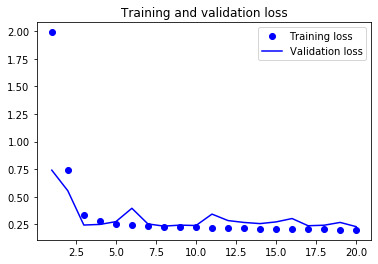

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

部分验证损失接近不包含学习的基准方法，但这个结果并不可靠。这也展示了首先建立这个基准方法的优点，事实证明，超越这个基准并不容易。我们的常识中包含了大量有价值的信息，而机器学习模型并不知道这些信息。

你可能会问，如果从数据到目标之间存在一个简单且表现良好的模型（即基于常识的基准方法），那为什么我们训练的模型没有找到这个模型并进一步改进呢？原因在于，这个简单的解决方案并不是训练过程所要寻找的目标。我们在模型空间（即假设空间）中搜索解决方案，这个模型空间是具有我们所定义的架构的所有两层网络组成的空间。这些网络已经相当复杂了。如果你在一个复杂模型的空间中寻找解决方案，那么可能无法学到简单且性能良好的基准方法，虽然技术上来说它属于假设空间的一部分。通常来说，这对机器学习是一个非常重要的限制：**如果学习算法没有被硬编码要求去寻找特定类型的简单模型，那么有时候参数学习是无法找到简单问题的简单解决方案的**。

### 6.3.5 第一个循环网络基准
第一个全连接方法的效果并不好，但这并不意味着机器学习不适用于这个问题。前一个方法首先将时间序列展平，这从输入数据中删除了时间的概念。我们来看一下数据本来的样子：它是一个序列，其中因果关系和顺序都很重要。我们将尝试一种循环序列处理模型，它应该特别适合这种序列数据，因为它利用了数据点的时间顺序，这与第一个方法不同。

我们将使用`Chung`等人在2014年开发的`GRU`层，而不是上一节介绍的`LSTM`层。`门控循环单元`（GRU，gated recurrent unit）层的工作原理与`LSTM`相同。但它做了一些简化，因此运行的计算代价更低（虽然表示能力可能不如`LSTM`）。机器学习中到处可以见到这种计算代价与表示能力之间的折中。

> CHUNG J, GULCEHRE C, CHO K, et al. Empirical evaluation of gated recurrent neural networks on sequence modeling. [C]//Conference on Neural Information Processing Systems, 2014

In [23]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 90s 180ms/step - loss: 0.3038 - val_loss: 0.3127
Epoch 2/20
500/500 [==============================] - 89s 177ms/step - loss: 0.2848 - val_loss: 0.3272
Epoch 3/20
500/500 [==============================] - 89s 178ms/step - loss: 0.2778 - val_loss: 0.3545
Epoch 4/20
500/500 [==============================] - 89s 178ms/step - loss: 0.2767 - val_loss: 0.3598
Epoch 5/20
500/500 [==============================] - 90s 179ms/step - loss: 0.2698 - val_loss: 0.3389
Epoch 6/20
500/500 [==============================] - 89s 178ms/step - loss: 0.2662 - val_loss: 0.3440
Epoch 7/20
500/500 [==============================] - 90s 181ms/step - loss: 0.2627 - val_loss: 0.3703
Epoch 8/20
500/500 [==============================] - 90s 179ms/step - loss: 0.2572 - val_loss: 0.3683
Epoch 9/20
500/500 [==============================] - 89s 178ms/step - loss: 0.2527 - val_loss: 0.3339
Epoch 10/20
500/500 [==============================] - 89s 178ms/step - l

显示模型结果：

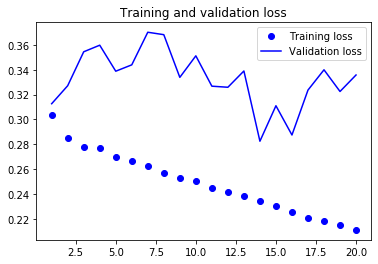

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

新的验证`MAE`约为0.265（在开始显著过拟合之前），反标准化转换成温度的平均绝对误差为`2.35℃`。与最初的误差`2.57℃`相比，这个结果确实有所提高，但可能仍有改进的空间。

### 6.3.6 使用循环dropout来降低过拟合
从训练和验证曲线中可以明显看出，模型出现过拟合：几轮过后，训练损失和验证损失就开始显著偏离。我们已经学过使用`dropout`降低过拟合，即将某一层的输入单元随机设为0，其目的是打破该层训练数据中的偶然相关性。但在循环网络中正确地使用`dropout`并不简单。人们早就知道，在循环层前面应用`dropout`会妨碍学习过程，而不是有所帮助。

2015 年，在关于贝叶斯深度学习的博士论文中，`Yarin Gal`确定了在循环网络中使用`dropout`的正确方法：对每个时间步应该使用相同的`dropout`掩码（dropout mask，相同模式的舍弃单元），而不是让`dropout`掩码随着时间步的增加而随机变化。此外，为了对`GRU`、`LSTM`等循环层得到的表示做正则化，应该将不随时间变化的`dropout`掩码应用于层的内部循环激活（叫作`循环dropout掩码`）。对每个时间步使用相同的`dropout`掩码，可以让网络沿着时间正确地传播其学习误差，而随时间随机变化的`dropout`掩码则会破坏这个误差信号，并且不利于学习过程。

> 参见`Yarin Gal`的博士论文“Uncertainty in deep learning”

`Yarin Gal`使用`Keras`开展这项研究，并帮助将这种机制直接内置到`Keras`循环层中。`Keras`的每个循环层都有两个与`dropout`相关的参数：一个是`dropout`，它是一个浮点数，指定该层输入单元的`dropout`比率；另一个是`recurrent_dropout`，指定循环单元的`dropout`比率。我们向`GRU`层中添加`dropout`和循环`dropout`，看一下这么做对过拟合的影响。因为使用`dropout`正则化的网络总是需要更长的时间才能完全收敛，所以网络训练轮次增加为原来的2倍。

> **Add by alex**
> 
> 原书代码运行结果loss为NAN，参考下面说明：
> Checked recurrent_dropout in details, it seems that the issue only occurs in implementation=2 which is the default in tf 2.0 (we changed from implementation 1 to 2 as default value). In short, the implementation 1 and 2 should be numerically same, but just be implemented differently. 1 uses more samll tensors and slide weights into individual gates, while 2 uses more bulk matmul.
> 
> The issue I believe is caused by an oversight when implementation 2 is introduce. When dropout is enabled, we applied the same dropout masks for all the gates, since it doesn't slide weights into individual gates. This might cause some numerical instability, eg if both candidate gate and forget gate gets the same masked state, they might be contradictory to each other (I don't have the detailed math proof here).
> 
> In short, for now you can build GRU with "implementation=1" in the init arg to walk around issue. I will send a fix very soon to force the implementation == 1 if the recurrent_dropout is specified.
> 
> [link](https://github.com/tensorflow/tensorflow/issues/32987)

In [33]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1]), implementation=1))
model.add(layers.Dense(1))
model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 84s 167ms/step - loss: 0.3514 - val_loss: 0.7264
Epoch 2/40
500/500 [==============================] - 84s 169ms/step - loss: 0.3154 - val_loss: 0.6854
Epoch 3/40
500/500 [==============================] - 83s 166ms/step - loss: 0.3091 - val_loss: 0.6278
Epoch 4/40
500/500 [==============================] - 84s 167ms/step - loss: 0.3023 - val_loss: 0.6712
Epoch 5/40
500/500 [==============================] - 85s 169ms/step - loss: 0.2995 - val_loss: 0.6801
Epoch 6/40
500/500 [==============================] - 84s 168ms/step - loss: 0.2969 - val_loss: 0.6849
Epoch 7/40
500/500 [==============================] - 84s 168ms/step - loss: 0.2933 - val_loss: 0.6594
Epoch 8/40
500/500 [==============================] - 82s 164ms/step - loss: 0.2918 - val_loss: 0.6016
Epoch 9/40
500/500 [==============================] - 83s 166ms/step - loss: 0.2918 - val_loss: 0.5800
Epoch 10/40
500/500 [==============================] - 84s 168ms/step - l

结果显示前30个轮次不再过拟合。不过，虽然评估分数更加稳定，但最佳分数并没有比之前低很多。

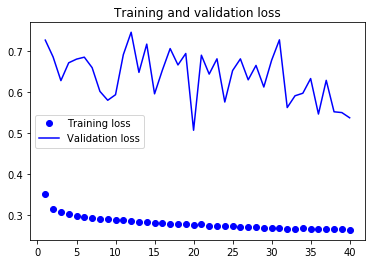

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 6.3.7 循环层堆叠
模型不再过拟合，但似乎遇到了性能瓶颈，所以我们应该考虑增加网络容量。回想一下机器学习的通用工作流程：增加网络容量通常是一个好主意，直到过拟合变成主要的障碍（假设你已经采取基本步骤来降低过拟合，比如使用`dropout`）。只要过拟合不是太严重，那么很可能是容量不足的问题。

增加网络容量的通常做法是增加每层单元数或增加层数。`循环层堆叠`（recurrent layer stacking）是构建更加强大的循环网络的经典方法，例如，目前谷歌翻译算法就是7个大型`LSTM`层的堆叠——这个架构很大。

在`Keras`中逐个堆叠循环层，所有中间层都应该返回完整的输出序列（一个3D张量），而不是只返回最后一个时间步的输出。这可以通过指定`return_sequences=True`来实现。

In [ ]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
 24/500 [>.............................] - ETA: 3:20 - loss: nan